# Ethereum Price Prediction Using LSTMs 

# Loading Basic Libraries

In [1]:
from google.cloud import bigquery
import tensorflow as tf
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

import datetime
import requests
import sys, os

#changing default figure renderer for github display
import plotly.io as pio
pio.renderers
pio.renderers.default = "svg"

# Defining Basic Plotting Function

In [2]:
def plotData(df, x_column, y_column): 
    """simply the input plot data from a dataframe"""

    figure = go.Figure()
    figure.add_trace(go.Scatter(x=df[x_column],y=df[y_column],mode='lines'))
    
    figure.update_xaxes(title = "Time")
    figure.update_yaxes(title = "Price")
    
    figure.show() 

# Defining API calls to obtain Ethereum Prices

These API calls will obtain the following features for the specificed time period: Time, high price, low price, open price, volume-from, volume-to, close price, conversionType, conversionSymbol, and timestamp.


In [3]:
#Documentation and explanation of the API request can be found here:
#https://min-api.cryptocompare.com/documentation?

#my api key:
my_api_key = '72183b21006f095800f3b2e4b665adaae27d08098ec380c72b3ee87d25c8164f'

def price(symbol, comparison_symbols=['USD'], exchange=''):
    """
    Obtain current price of a cryptocurrency
    """
    
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}&api_key={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper(),my_api_key)
    
    #this would be the same as the following code for ETH price and BTC,USD,EUR comparisons
    #url = 'https://min-api.cryptocompare.com/data/price?fsym=ETH & tsyms=BTC,USD,EUR & api_key={my_api_key}'

    #adding the exchange if we want a specefic exchange
    if exchange:
        url += '&e={}'.format(exchange) 
        
    page = requests.get(url)
    data = page.json()
    return data

    #example use: 
    #price('LTC', exchange='Coinbase')

def daily_price_historical(symbol, comparison_symbol, limit=1, aggregate=1, exchange='', allData='true'):
    """
    Obtain historical price of a cryptocurrency with daily timestep
    """
    
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}&api_key={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData,my_api_key)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time] #seting up timestamp from time column
    return df

    #example use:
    #df = daily_price_historical('BTC', 'USD')
    #print('Max length = %s' % len(df))
    #print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))
    #df.head()

def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    """
    Obtain historical price of a cryptocurrency with hourly timestep
    """
    
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}&api_key={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate,my_api_key)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

    #example use:
    #time_delta = 1 # Bar width in hours
    #df = hourly_price_historical('BTC', 'USD', 9999, time_delta)
    #print('Max length = %s' % len(df))
    #print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    """
    Obtain historical price of a cryptocurrency with minute timestep
    """
    
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}&api_key={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate,my_api_key)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

    #example use:
    #time_delta = 1 # Bar width in minutes
    #df = minute_price_historical('BTC', 'USD', 9999, time_delta)
    #print('Max length = %s' % len(df))
    #print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

# Obtaining and Viewing Data

Max length = 4080
Max time = 4079 days 00:00:00


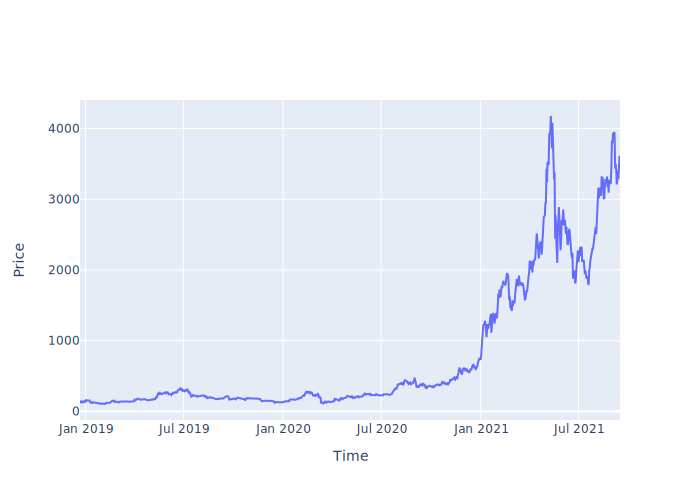

In [4]:
price_daily = daily_price_historical('ETH', 'USD')
print('Max length = %s' % len(price_daily))
print('Max time = %s' % (price_daily.timestamp.max() - price_daily.timestamp.min()))
price_daily.tail()

plotData(price_daily.iloc[-1000:],"timestamp","close")

In [5]:
price_daily.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp
0,1279324800,0.0,0.0,0.0,0.0,0.0,0.0,direct,,2010-07-16 18:00:00
1,1279411200,0.0,0.0,0.0,0.0,0.0,0.0,direct,,2010-07-17 18:00:00
2,1279497600,0.0,0.0,0.0,0.0,0.0,0.0,direct,,2010-07-18 18:00:00
3,1279584000,0.0,0.0,0.0,0.0,0.0,0.0,direct,,2010-07-19 18:00:00
4,1279670400,0.0,0.0,0.0,0.0,0.0,0.0,direct,,2010-07-20 18:00:00


# Setting up RNN Configuration

# Configuring model into a single class

In [6]:
class crypto_LSTM():
    """
    Class that definines and implements an LSTM model for the prediction of Ethereum Prices
    """
    
    # initializing default configuration and allowing for customization if needed
    def __init__(self, input_size=None, grouped_inputs=None,
                 input_overlap=None, layer_size=None, num_layers=None,
                keep_prob=None, start_learning_rate=None, initial_epochs=None,
                decay_learning_rate=None, max_epochs=None, batch_size=None):
        
        """
        Arguments:
            input_size = number of time inputs into a single time-step in the RNN.
            grouped_inputs = number of inputs used during a training instance the "unrolled" version of the RNN
            input_overlap = overlap beetween windows when choosing input data 
            layer_size = setting number of units in an LSTM layer (layer size)
            num_layers =  setting number of stacked LSTM layers (number of layers)
            keep_prob = percentage of cell units to keep in the dropout operation during training
            learning_rate = setting start learning rate 
            initial_epochs = setting number of epochs we will use initial learning rate
            decay_learning_rate = setting decay in learning rate after 1st epoch
            max_epochs = maximum number of epochs used for training
            batch_size = setting mini batch size

        """
    
        if input_size is None:
            self.input_size = 3
        else:
            self.input_size = input_size       
    
        if grouped_inputs is None:
            self.grouped_inputs = 2
        else:
            self.grouped_inputs = grouped_inputs
                
        if input_overlap is None:
            self.input_overlap = 3
        else:
            self.input_overlap = input_overlap
        
        if layer_size is None:
            self.layer_size = 128
        else:
            self.layer_size = layer_size
        
        if num_layers is None:
            self.num_layers = 1
        else:
            self.num_layers = num_layers

        if keep_prob is None:
            self.keep_prob = 0.8
        else:
            self.keep_prob = keep_prob
        
        
        if start_learning_rate is None:
            self.start_learning_rate = 0.001
        else:
            self.start_learning_rate = start_learning_rate

        if initial_epochs is None:
            self.initial_epochs = 5
        else:
            self.initial_epochs = initial_epochs

        if decay_learning_rate is None:
            self.decay_learning_rate = 0.99
        else:
            self.decay_learning_rate = decay_learning_rate

        if max_epochs is None:
            self.max_epochs = 3
        else:
            self.max_epochs = max_epochs

        if batch_size is None:
            self.batch_size = 64
        else:
            self.batch_size = batch_size
                
        self.build_model()
        
    def build_model(self):
        """build the model based on the configuration specified in the contstructor"""
        
        self.model = Sequential() #linear stack of layers
    
        #input layer
        self.model.add(LSTM(self.layer_size,
                input_shape =(self.grouped_inputs, self.input_size), #input shape
                return_sequences = True #neccesary if multiple LSTM layers
                )
             )
    
        #building intermediate layers
        for i in range(self.num_layers-2):
            
            self.model.add(LSTM(self.layer_size,
                    recurrent_dropout = (1-self.keep_prob), #dropout layer of the outputs
                    return_sequences = True)
                     )
        
        #output layer
        self.model.add(LSTM(self.layer_size,
                recurrent_dropout = (1-self.keep_prob))
                 )
        
        self.model.add(Dense(units = self.input_size))
             
        #model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
        self.model.compile(optimizer="RMSprop", loss="mse", metrics=["mae","mse"])
                

    #need to prepare data before running this
    def train_and_predict(self,df):
        """
        train the model and obtain a prediction
        """
        
        #run data preparation
        self.prepare_data(df)
                
        #train model
        self.model.fit(self.train_data,self.train_labels, epochs = self.max_epochs)
        
        #predictt
        self.prediction = self.model.predict(self.test_data)

    def prepare_data(self,df,total_steps=1000,train_test_split = 0.8):
        """
        Method to split raw data into time-step separated training and testing data
    
        Arguments:
            df =  data frame with all the data
            total_steps = number of time steps we want to investigate 
            train_test_split = what percentage do we want the training data be of the total data set? 
        """
    
        #making a list sequence of closing prices
        l = []
        for i in df.iloc[-total_steps:]["close"]:
            l.append(i)
                
        #formatting the data into a list of arrays (a 3-D array)
        #each array has the size of the number of time steps included in each input
        #each array does not share numbers with previous array (we can change that)

        seq = [np.array(
                l[self.input_size*i : self.input_size*(i + 1)]
                ) 
               for i in range(len(l) // self.input_size)
              ]

        #non dimensionalize with respect to last unkwnown value in previous window
        seq_ref = seq.copy()
        seq[0] = seq_ref[0]/seq_ref[0][0] #first window normalization is different
 
        for i in range(1,len(seq)):
            seq[i] = seq_ref[i]/seq_ref[i-1][-1]

        # group inputs by "grouped inputs" parameter (how many inputs are used as a training istance in unrolled version RNN)
        features = np.array([seq[i: i + self.grouped_inputs] for i in range(len(seq) - self.grouped_inputs)])
        labels = np.array([seq[i + self.grouped_inputs] for i in range(len(seq) - self.grouped_inputs)])
    
        #splitting the train-test data 
        cutoff = int(features.shape[0]*train_test_split)
    
        self.train_data = features[:cutoff]
        self.train_labels = labels[:cutoff]
        self.test_data = features[cutoff:]
        self.test_labels = labels[cutoff:]    
        
    def plotArrays(self, plotBoth=True): 
        '''plots the training dataset array.
        The "plotBoth" flag plots predictions in addition to just the training data.
        Note the .ravel function flattens an array'''
    
        figure = go.Figure()
        figure.add_trace(go.Scatter(y=self.test_labels.ravel()
                                   ,x=list(range(len(self.test_labels.ravel()))),
                                   mode='lines',
                                   name="labels"
                                   )
                            )
    
        if plotBoth:
            figure.add_trace(go.Scatter(y=self.prediction.ravel()
                                   ,x=list(range(len(self.prediction.ravel()))),mode='lines',
                                    name = "prediction"
                                    )
                            )
        
        figure.update_xaxes(title = "Time")
        figure.update_yaxes(title = "Normalized Price")
    
        figure.show()   

# Running the Model

2021-09-16 16:11:37.010382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-16 16:11:37.407223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/3
9/9 [==============================] - 3s 9ms/step - loss: 0.7188 - mae: 0.8168 - mse: 0.7188
Epoch 2/3
9/9 [==============================] - 0s 10ms/step - loss: 0.0107 - mae: 0.0781 - mse: 0.0107
Epoch 3/3
9/9 [==============================] - 0s 9ms/step - loss: 0.0081 - mae: 0.0694 - mse: 0.0081


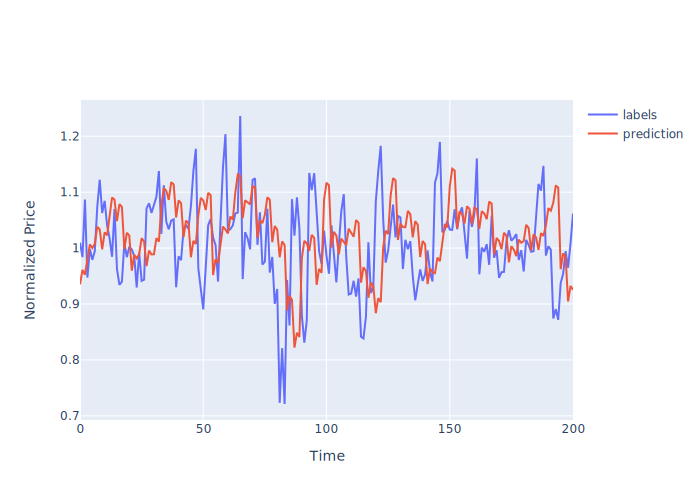

In [7]:
#initialize the model
model = crypto_LSTM()

#predictions
model.train_and_predict(price_daily)

#plotting
model.plotArrays()

Things left to do:
    -use word embeddings for reddit posts (instead of bag of words)
    -change aronud input size, grouped inputs, and input overalp. 
    -move around normalization value (it could just be last data point in previous sample)
    -subtract 1 to make negative movements negative and positive movements positive
    -can use different defenitions of the lstm cell (GRUs)
    -make the NN a functional (not sequential) network, where layers can connect to many other layers. 